In [27]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt

from astropy.coordinates import SkyCoord
from astropy.table import QTable, vstack
%matplotlib notebook

import seaborn as sns
pal = sns.color_palette("colorblind")

import pickle

from matplotlib.ticker import MultipleLocator

from astroquery.simbad import Simbad
import linmix

In [2]:
# Load Full Data
full_ideal_res = QTable.read("Data/FIT_AND_CLOUDY_RESULTS.fits")

# Load High Ion Results
summed_columns = QTable.read("Data/SUMMED_ION_COLUMNS_wHII.fits")
    
# Load Neutral Hydrogen Data
with open("Data/STREAM_MOMENT_HI_v_gt_150.pkl", "rb") as f:
    stream_data = pickle.load(f)


In [4]:
# Get summed HII columns per sightline
source_names = ['PKS0637-75',
 'HE0246-4101',
 'RBS144',
 'PKS0552-640',
 'PKS0202-76',
 'HE0003-5023',
 'UVQSJ045415.95-611626.6',
 'HE0419-5657',
 'UKS0242-724',
 'IRAS_F21325-6237',
 'IRAS_Z06229-6434',
 'RBS567',
 'PKS0558-504',
 'RX_J0503.1-6634',
 '1H0419-577',
 'RBS1992',
 'ESO031-G08',
 'PKS0355-483',
 'HE0153-4520',
 'HE0439-5254',
 'HE0038-5114',
 'HE0226-4110',
 'HE2336-5540',
 'RBS563',
 'HE0331-4112',
 'HE0435-5304',
 'HE2305-5315',
 'FAIRALL9']
summed_N_HII, impact_pars, sn, low_logT, low_logT_err, source_names_use = [], [], [], [], [], []
for source_name in source_names:
    res_rows = full_ideal_res[full_ideal_res["SOURCE"] == source_name]
    if len(res_rows) > 0:
        source_names_use.append(source_name)
        N_HII = np.sum(res_rows["N_HII"])
        summed_N_HII.append(N_HII.value)
        impact_pars.append(res_rows["RHO_LMC"][0].value)
        sn.append(source_name)
        low_logT.append(np.log10(np.mean(res_rows["Te"]).value))
        low_logT_err.append(1/np.log(10) * np.std(res_rows["Te"]).value/np.mean(res_rows["Te"]).value)
    
summed_N_HII = np.array(summed_N_HII)*u.cm**-2
impact_pars = np.array(impact_pars)*u.kpc
sn = np.array(sn)
low_logT = np.array(low_logT)
low_logT_err = np.array(low_logT_err)

# Mass Calculations

In [5]:
distance = 50*u.kpc
from astropy.constants import m_p as proton_mass

In [6]:
from scipy.stats import siegelslopes
from seaborn.algorithms import bootstrap

## Photoionized Phase

In [20]:
# Slope Finding method for bootstrapping Photoionized CGM
mask = ~np.isnan(summed_N_HII.value)
def slope_finder(inds, y = np.log10(summed_N_HII.value)[mask], x = impact_pars[mask]):
    xx = x[inds]
    yy = y[inds]
    return siegelslopes(yy, x = xx)

In [21]:
slope, intercept = bootstrap(np.arange(len(impact_pars[mask])), func = slope_finder, n_boot = 10000).T

In [23]:
mean_slope = slope.mean()
std_slope = slope.std()

In [24]:
xx = np.linspace(0,50,1000)
all_lines = np.array([m*xx + b for (m,b) in zip(slope,intercept)])
lo, med, hi = np.percentile(all_lines, (16,50,84), axis = 0)


dr = np.diff(xx)[0]*u.kpc
dA = 2*np.pi*xx*u.kpc*dr
mass = dA * proton_mass * (10**all_lines)*u.cm**(-2)

f_cov_lo = 23/28.

summed_masses_50_kpc = np.sum(mass.to(u.Msun), axis = 1) * f_cov_lo
lo_mass, med_mass, hi_mass = np.percentile(summed_masses_50_kpc, (16,50,84))

minus_mass_err = med_mass - lo_mass
plus_mass_err = hi_mass - med_mass

log_minus_mass_err = 1/np.log(10)*minus_mass_err.value/med_mass.value
log_plus_mass_err = 1/np.log(10)*plus_mass_err.value/med_mass.value
log_med_mass = np.log10(med_mass.value)

## 10^4.9 K Interfaces

### Equilibrium CIE

In [37]:
log_metallicity = -1

In [38]:
# Linear Regression
## rho > 7 kpc



xC = summed_columns["RHO_LMC"].value
yC = summed_columns["CIE_LOG_N_HII"] - log_metallicity 
yC_err = summed_columns["CIE_LOG_N_ERR_HII"]

upper_lim_C = summed_columns["CIE_LOG_N_ERR_HII"] < 0

delta_C = np.invert(upper_lim_C)
xsig_C = np.zeros_like(xC)
ysig_C = yC_err[:]
lmcens_C = linmix.LinMix(xC[xC>7], yC[xC>7], xsig_C[xC>7], ysig_C[xC>7], delta=delta_C[xC>7], K=2)
lmcens_C.run_mcmc(silent=True)

yints_C = lmcens_C.chain['alpha']
slopes_C = lmcens_C.chain['beta']


mean_yint_C = yints_C.mean()
mean_slope_C = slopes_C.mean()

gt7_xx = np.linspace(0,50,1000)
all_lines_C = np.array([m*gt7_xx + b for (m,b) in zip(slopes_C, yints_C)])

gt7_lo_line_C, gt7_med_line_C, gt7_hi_line_C = np.percentile(all_lines_C, (16,50,84), axis = 0)
gt7_mean_line_C = mean_slope_C*gt7_xx + mean_yint_C




In [39]:
dr = np.diff(xx)[0]*u.kpc
dA = 2*np.pi*xx*u.kpc*dr
mass = dA * proton_mass * (10**all_lines_C)*u.cm**(-2)

under_30_mask = xx < 30
fcov_in = 0.78
fcov_out = 0.3

summed_masses_50_kpc = np.sum(mass[:,under_30_mask].to(u.Msun), axis = 1) * fcov_in
summed_masses_50_kpc += np.sum(mass[:,~under_30_mask].to(u.Msun), axis = 1) * fcov_out
lo_mass, med_mass, hi_mass = np.percentile(summed_masses_50_kpc, (16,50,84))
minus_mass_err = med_mass - lo_mass
plus_mass_err = hi_mass - med_mass

gt7_CIE_log_minus_mass_err = 1/np.log(10)*minus_mass_err.value/med_mass.value
gt7_CIE_log_plus_mass_err = 1/np.log(10)*plus_mass_err.value/med_mass.value
gt7_CIE_log_med_mass = np.log10(med_mass.value)

In [52]:
gt7_CIE_log_med_mass

8.569271855189667

### Time Dependent Isochoric

In [62]:
# Linear Regression
## rho > 7 kpc



xI = summed_columns["RHO_LMC"].value
yI = summed_columns["ISOCh_LOG_N_HII"] 
yI_err = summed_columns["ISOCh_LOG_N_ERR_HII"]

upper_lim_I = summed_columns["ISOCh_LOG_N_ERR_HII"] < 0

delta_I = np.invert(upper_lim_I)
xsig_I = np.zeros_like(xI)
ysig_I = yI_err[:]
lmcens_I = linmix.LinMix(xI[xI>7], yI[xI>7], xsig_I[xI>7], ysig_I[xI>7], delta=delta_I[xI>7], K=2)
lmcens_I.run_mcmc(silent=True)

yints_I = lmcens_I.chain['alpha']
slopes_I = lmcens_I.chain['beta']


mean_yint_I = yints_I.mean()
mean_slope_I = slopes_I.mean()

gt7_xx = np.linspace(0,50,1000)
all_lines_I = np.array([m*gt7_xx + b for (m,b) in zip(slopes_I, yints_I)])

gt7_lo_line_I, gt7_med_line_I, gt7_hi_line_I = np.percentile(all_lines_I, (16,50,84), axis = 0)
gt7_mean_line_I = mean_slope_I*gt7_xx + mean_yint_I




In [63]:
dr = np.diff(xx)[0]*u.kpc
dA = 2*np.pi*xx*u.kpc*dr
mass = dA * proton_mass * (10**all_lines_I)*u.cm**(-2)

under_30_mask = xx < 30
fcov_in = 0.78
fcov_out = 0.3

summed_masses_50_kpc = np.sum(mass[:,under_30_mask].to(u.Msun), axis = 1) * fcov_in
summed_masses_50_kpc += np.sum(mass[:,~under_30_mask].to(u.Msun), axis = 1) * fcov_out
lo_mass, med_mass, hi_mass = np.percentile(summed_masses_50_kpc, (16,50,84))
minus_mass_err = med_mass - lo_mass
plus_mass_err = hi_mass - med_mass

gt7_ISOCh_log_minus_mass_err = 1/np.log(10)*minus_mass_err.value/med_mass.value
gt7_ISOCh_log_plus_mass_err = 1/np.log(10)*plus_mass_err.value/med_mass.value
gt7_ISOCh_log_med_mass = np.log10(med_mass.value)

In [50]:
gt7_ISOCh_log_med_mass

8.66536063987932

In [59]:
# Low Temperature Isochoric Solution

# Linear Regression
## rho > 7 kpc



xI = summed_columns["RHO_LMC"].value
yI = summed_columns["ISOCh_lowT_LOG_N_HII"] 
yI_err = summed_columns["ISOCh_lowT_LOG_N_ERR_HII"]

upper_lim_I = summed_columns["ISOCh_lowT_LOG_N_ERR_HII"] < 0

delta_I = np.invert(upper_lim_I)
xsig_I = np.zeros_like(xI)
ysig_I = yI_err[:]
lmcens_I = linmix.LinMix(xI[xI>7], yI[xI>7], xsig_I[xI>7], ysig_I[xI>7], delta=delta_I[xI>7], K=2)
lmcens_I.run_mcmc(silent=True)

yints_I = lmcens_I.chain['alpha']
slopes_I = lmcens_I.chain['beta']


mean_yint_I = yints_I.mean()
mean_slope_I = slopes_I.mean()

gt7_xx = np.linspace(0,50,1000)
all_lines_I_lt = np.array([m*gt7_xx + b for (m,b) in zip(slopes_I, yints_I)])

gt7_lo_line_I_lt, gt7_med_line_I_lt, gt7_hi_line_I_lt = np.percentile(all_lines_I, (16,50,84), axis = 0)
gt7_mean_line_I_lt = mean_slope_I*gt7_xx + mean_yint_I




In [60]:
dr = np.diff(xx)[0]*u.kpc
dA = 2*np.pi*xx*u.kpc*dr
mass = dA * proton_mass * (10**all_lines_I_lt)*u.cm**(-2)

under_30_mask = xx < 30
fcov_in = 0.78
fcov_out = 0.3

summed_masses_50_kpc = np.sum(mass[:,under_30_mask].to(u.Msun), axis = 1) * fcov_in
summed_masses_50_kpc += np.sum(mass[:,~under_30_mask].to(u.Msun), axis = 1) * fcov_out
lo_mass, med_mass, hi_mass = np.percentile(summed_masses_50_kpc, (16,50,84))
minus_mass_err = med_mass - lo_mass
plus_mass_err = hi_mass - med_mass

gt7_ISOCh_lowT_log_minus_mass_err = 1/np.log(10)*minus_mass_err.value/med_mass.value
gt7_ISOCh_lowT_log_plus_mass_err = 1/np.log(10)*plus_mass_err.value/med_mass.value
gt7_ISOCh_lowT_log_med_mass = np.log10(med_mass.value)

In [61]:
gt7_ISOCh_lowT_log_med_mass

9.78687173981668

## Corona (OVI)

### CIE

In [67]:
# # OVI
# from scipy.stats import siegelslopes
# from seaborn.algorithms import bootstrap

ovi_mask = ~np.isnan(summed_columns["LOG_N_OVI"]) & (summed_columns["LOG_N_ERR_OVI"] > 0)

def slope_finder(inds, y = summed_columns["CIE_CORONA_LOG_N_HII"][ovi_mask] - log_metallicity, 
                 x = summed_columns["RHO_LMC"][ovi_mask], 
                 y_err = summed_columns["CIE_CORONA_LOG_N_ERR_HII"][ovi_mask]):
    xx = x[inds]
    yy = y[inds] + y_err * np.random.randn(len(inds))
    return siegelslopes(yy, x = xx)

slope_O, intercept_O = bootstrap(np.arange(ovi_mask.sum()), func = slope_finder, n_boot = 10000).T
slope_O = slope_O[~np.isnan(slope_O)]
intercept_O = intercept_O[~np.isnan(intercept_O)]

mean_slope_O = slope_O.mean()
mean_yint_O = intercept_O.mean()
std_slope_O = slope_O.std()

# O_xx = np.linspace(0,50,1000)
O_xx = np.linspace(summed_columns["RHO_LMC"][ovi_mask].min().value,
                   summed_columns["RHO_LMC"][ovi_mask].max().value ,1000)


all_lines_O = np.array([m*O_xx + b for (m,b) in zip(slope_O, intercept_O)])


lo_line_O, med_line_O, hi_line_O = np.percentile(all_lines_O, (16,50,84), axis = 0)
mean_line_O = mean_slope_O*xx + mean_yint_O



In [68]:
dr = np.diff(xx)[0]*u.kpc
dA = 2*np.pi*xx*u.kpc*dr
mass = dA * proton_mass * (10**all_lines_O)*u.cm**(-2)

under_30_mask = xx < 30
fcov_in = 0.78
fcov_out = 0.3

summed_masses_50_kpc = np.sum(mass[:,under_30_mask].to(u.Msun), axis = 1) * fcov_in
summed_masses_50_kpc += np.sum(mass[:,~under_30_mask].to(u.Msun), axis = 1) * fcov_out
lo_mass, med_mass, hi_mass = np.percentile(summed_masses_50_kpc, (16,50,84))
minus_mass_err = med_mass - lo_mass
plus_mass_err = hi_mass - med_mass

CIE_Corona_log_minus_mass_err = 1/np.log(10)*minus_mass_err.value/med_mass.value
CIE_Corona_log_plus_mass_err = 1/np.log(10)*plus_mass_err.value/med_mass.value
CIE_Corona_log_med_mass = np.log10(med_mass.value)

In [69]:
CIE_Corona_log_med_mass

8.548742487873145

### Isochoric

In [64]:
# # OVI
# from scipy.stats import siegelslopes
# from seaborn.algorithms import bootstrap

ovi_mask = ~np.isnan(summed_columns["LOG_N_OVI"]) & (summed_columns["LOG_N_ERR_OVI"] > 0)

def slope_finder(inds, y = summed_columns["ISOCh_CORONA_LOG_N_HII"][ovi_mask], 
                 x = summed_columns["RHO_LMC"][ovi_mask], 
                 y_err = summed_columns["ISOCh_CORONA_LOG_N_ERR_HII"][ovi_mask]):
    xx = x[inds]
    yy = y[inds] + y_err * np.random.randn(len(inds))
    return siegelslopes(yy, x = xx)

slope_O, intercept_O = bootstrap(np.arange(ovi_mask.sum()), func = slope_finder, n_boot = 10000).T
slope_O = slope_O[~np.isnan(slope_O)]
intercept_O = intercept_O[~np.isnan(intercept_O)]

mean_slope_O = slope_O.mean()
mean_yint_O = intercept_O.mean()
std_slope_O = slope_O.std()

# O_xx = np.linspace(0,50,1000)
O_xx = np.linspace(summed_columns["RHO_LMC"][ovi_mask].min().value,
                   summed_columns["RHO_LMC"][ovi_mask].max().value ,1000)


all_lines_O_I = np.array([m*O_xx + b for (m,b) in zip(slope_O, intercept_O)])


lo_line_O_I, med_line_O_I, hi_line_O_I = np.percentile(all_lines_O_I, (16,50,84), axis = 0)
mean_line_O_I = mean_slope_O*xx + mean_yint_O



In [65]:
dr = np.diff(xx)[0]*u.kpc
dA = 2*np.pi*xx*u.kpc*dr
mass = dA * proton_mass * (10**all_lines_O_I)*u.cm**(-2)

under_30_mask = xx < 30
fcov_in = 0.78
fcov_out = 0.3

summed_masses_50_kpc = np.sum(mass[:,under_30_mask].to(u.Msun), axis = 1) * fcov_in
summed_masses_50_kpc += np.sum(mass[:,~under_30_mask].to(u.Msun), axis = 1) * fcov_out
lo_mass, med_mass, hi_mass = np.percentile(summed_masses_50_kpc, (16,50,84))
minus_mass_err = med_mass - lo_mass
plus_mass_err = hi_mass - med_mass

ISOCh_Corona_log_minus_mass_err = 1/np.log(10)*minus_mass_err.value/med_mass.value
ISOCh_Corona_log_plus_mass_err = 1/np.log(10)*plus_mass_err.value/med_mass.value
ISOCh_Corona_log_med_mass = np.log10(med_mass.value)

In [66]:
ISOCh_Corona_log_med_mass

8.657823088004847

## HI Checks

In [71]:
#LMC Impact Parameter
LMC_coord = SkyCoord(l = 280.4652, b = -32.8884, distance = 50, 
                     unit = (u.deg, u.deg, u.kpc), frame = "galactic")

# HI coords
hi_coords = SkyCoord(l = -stream_data['l'], b = stream_data["b"], 
                     distance = 50*np.ones_like(stream_data["b"]),
                     unit = (u.deg, u.deg, u.kpc), frame = "galactic")

# impact parameter
hi_impact_par = np.tan(LMC_coord.separation(hi_coords))*50*u.kpc

# 50 kpc mask
rho_mask = hi_impact_par < 50*u.kpc
# sensitivity mask
nhi_mask = stream_data["moment_v150"] > 2.3e18

log_NHI = np.log10(stream_data["moment_v150"][nhi_mask & rho_mask])
rho_HI = hi_impact_par[nhi_mask & rho_mask]

In [72]:
# Get source coords
source_info = vstack([Simbad.query_objects([sn]) for sn in source_names_use])


source_coords = SkyCoord(ra = source_info["RA"], 
                    dec = source_info["DEC"], 
                    unit = (u.hourangle, u.deg),
                    frame = "icrs")

In [73]:
# find matching closest spectra in HI
idx, d2d, d3d = source_coords.match_to_catalog_sky(hi_coords.flatten())

In [74]:
# Get measurements
log_NHI_obs_dirs = np.log10(stream_data['moment_v150']).flatten()[idx]

masked_log_NHI = np.ma.masked_array(data = log_NHI_obs_dirs, 
                                    mask = ((log_NHI_obs_dirs < np.log10(2.3e18)) | 
                                            np.isnan(log_NHI_obs_dirs)))

/var/folders/yk/6d2kh4j15294grmssy2gp_b40000gn/T/ipykernel_64396/3938848030.py:2: RuntimeWarning: invalid value encountered in log10
  log_NHI_obs_dirs = np.log10(stream_data['moment_v150']).flatten()[idx]


# Figure 3

<IPython.core.display.Javascript object>


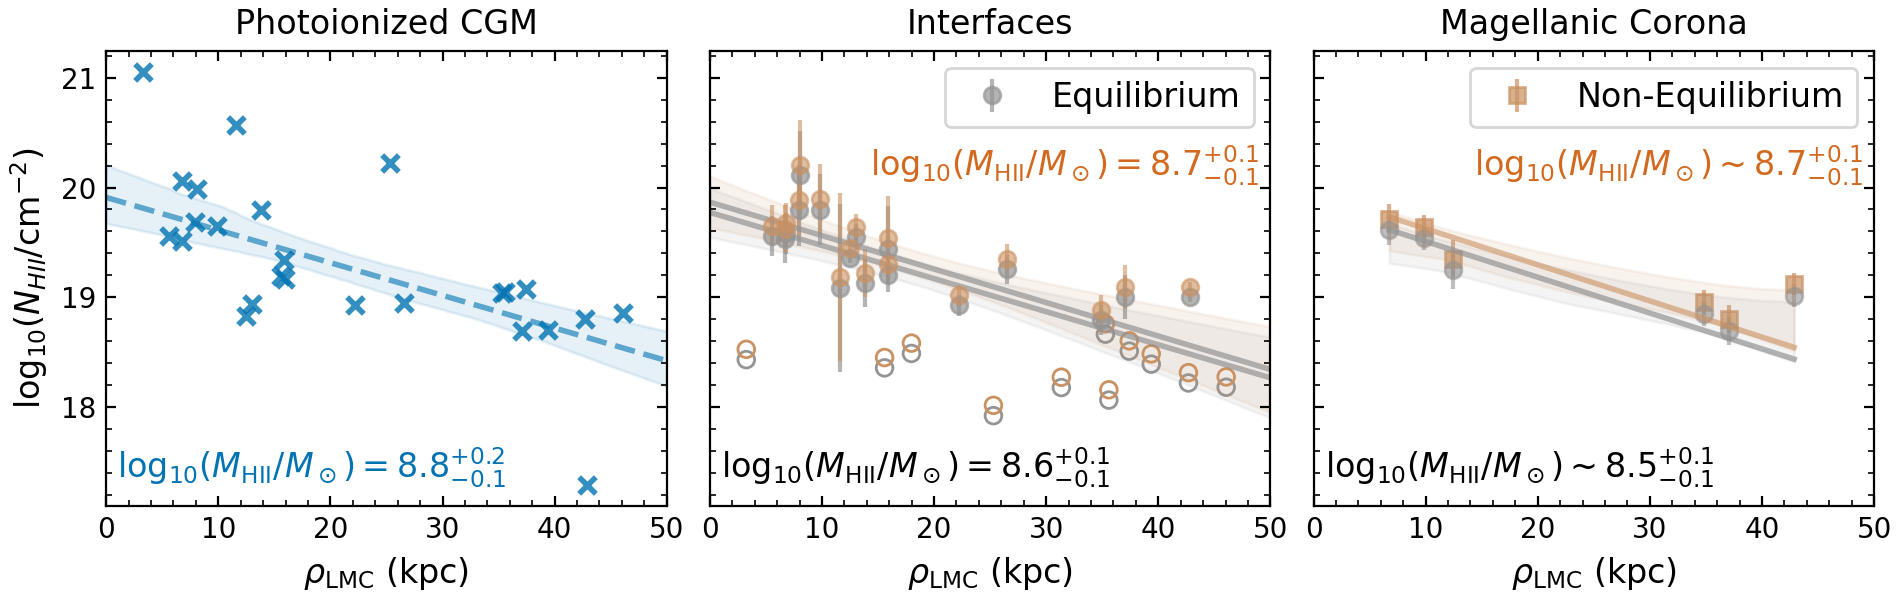

In [117]:
xx = np.linspace(0,50,1000)


fig,axs = plt.subplots(1,3, constrained_layout = True, figsize = (9.5,3), 
                       sharex = True, sharey = True)

axs = {"B":axs[0], "C":axs[1], "A":axs[2]}

ax = axs["B"]



ax.scatter(impact_pars, np.log10(summed_N_HII.value), 
           color = pal[0], alpha = 0.8, marker = "x", label = "HII", lw = 2)




xlim = ax.get_xlim()


xxx = np.linspace(0,50,100)
def yy(xx, slope = slope.mean(), intercept = intercept.mean()):
    return slope*xx + intercept
ax.plot(xxx, yy(xxx), color = pal[0], lw = 2, alpha = 0.6,  ls = "--",
#         label = r"Slope = ${0:.3f} \pm {1:.3f}$".format(mean_slope, std_slope),
       )


ax.fill_between(xx, lo, hi, color = pal[0], alpha = 0.1)

# lg = ax.legend(fontsize = 12, loc = 1, ncol = 2)


xlim = ax.set_xlim(0,50)


ax.text(1, 17.25, r"$\log_{{10}}(M_\mathrm{{HII}}/M_\odot$)$= {0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}$".format(log_med_mass, 
                                                                                          log_plus_mass_err, 
                                                                                          log_minus_mass_err),
       ha = "left", va = "bottom", fontsize = 12, color = pal[0])



ax.set_xlabel(r"$\rho_\mathrm{LMC}$ (kpc)", fontsize = 12)
ax.set_ylabel(r"$\log_{10}(N_{HII}/\mathrm{cm}^{-2})$", fontsize = 12)


# Interfaces
ax1 = axs["C"]

ax1.set_xlabel(r"$\rho_\mathrm{LMC}$ (kpc)", fontsize = 12)

XX = summed_columns["RHO_LMC"]
YY_CIE = summed_columns["CIE_LOG_N_HII"] - log_metallicity
YY_CIE_ERR = summed_columns["CIE_LOG_N_ERR_HII"]
upper_lim_CIE = YY_CIE_ERR < 0

YY_ISO = summed_columns["ISOCh_LOG_N_HII"]
YY_ISO_ERR = summed_columns["ISOCh_LOG_N_ERR_HII"]
upper_lim_ISO = YY_ISO_ERR < 0

YY_ISO_LT = summed_columns["ISOCh_lowT_LOG_N_HII"]
YY_ISO_LT_ERR = summed_columns["ISOCh_lowT_LOG_N_ERR_HII"]
upper_lim_ISO_LT = YY_ISO_LT_ERR < 0


ax1.scatter(XX[upper_lim_CIE], YY_CIE[upper_lim_CIE], 
           edgecolor = pal[7], marker = "o", facecolor = "none")
ax1.errorbar(XX[~upper_lim_CIE], YY_CIE[~upper_lim_CIE], YY_CIE_ERR[~upper_lim_CIE],
            fmt = "o", color = pal[7], alpha = 0.7, label = "Equilibrium")

ax1.plot(xx, gt7_mean_line_C, color = pal[7], lw = 2, alpha= 0.7, ls = "-")
ax1.fill_between(xx, gt7_hi_line_C, gt7_lo_line_C, color = pal[7], alpha = 0.1)

ax1.text(1, 17.25, r"$\log_{{10}}(M_\mathrm{{HII}}/M_\odot$)$= {0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}$".format(gt7_CIE_log_med_mass, 
                                                                                          gt7_CIE_log_plus_mass_err, 
                                                                                          gt7_CIE_log_minus_mass_err), 
        ha = "left", va = "bottom", color = "k", fontsize = 12)


ax1.scatter(XX[upper_lim_ISO], YY_ISO[upper_lim_ISO], 
           edgecolor = pal[5], marker = "o", facecolor = "none")
ax1.errorbar(XX[~upper_lim_ISO], YY_ISO[~upper_lim_ISO], YY_ISO_ERR[~upper_lim_ISO],
            fmt = "o", color = pal[5], alpha = 0.6)

ax1.plot(xx, gt7_mean_line_I, color = pal[7], lw = 2, alpha= 0.7, ls = "-")
ax1.fill_between(xx, gt7_hi_line_I, gt7_lo_line_I, color = pal[5], alpha = 0.1)

ax1.text(49, 20.4, r"$\log_{{10}}(M_\mathrm{{HII}}/M_\odot$)$= {0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}$".format(gt7_ISOCh_log_med_mass, 
                                                                                          gt7_ISOCh_log_plus_mass_err, 
                                                                                          gt7_ISOCh_log_minus_mass_err), 
        ha = "right", va = "top", color = "chocolate", fontsize = 12)



lg = ax1.legend(fontsize = 12)






#OVI 
ax = axs["A"]
ax.set_xlabel(r"$\rho_\mathrm{LMC}$ (kpc)", fontsize = 12)


XX = summed_columns["RHO_LMC"][ovi_mask]
YY_CIE = summed_columns["CIE_CORONA_LOG_N_HII"][ovi_mask] - log_metallicity
YY_CIE_err = summed_columns["CIE_CORONA_LOG_N_ERR_HII"][ovi_mask]
YY_ISOCh = summed_columns["ISOCh_CORONA_LOG_N_HII"][ovi_mask]
YY_ISOCh_err = summed_columns["ISOCh_CORONA_LOG_N_ERR_HII"][ovi_mask]



ax.errorbar(XX, 
            YY_ISOCh, 
                  YY_ISOCh_err, fmt = "s", 
                  color=pal[5], zorder = -1, label = "Non-Equilibrium", alpha = 0.7)

ax.errorbar(XX, 
            YY_CIE, 
                  YY_CIE_err, fmt = "o", 
                  color=pal[7], zorder = -1, alpha = 0.6)

ax.plot(O_xx, mean_line_O, color = pal[7], lw = 2, alpha = 0.7, ls = "-")
ax.plot(O_xx, mean_line_O_I, color = pal[5], lw = 2, alpha = 0.6, ls = "-")

ax.fill_between(O_xx, lo_line_O, hi_line_O, color = pal[7], alpha = 0.1)

ax.fill_between(O_xx, lo_line_O_I, hi_line_O_I, color = pal[5], alpha = 0.1)

lg = ax.legend( fontsize = 12)

ax.text(49, 20.4, r"$\log_{{10}}(M_\mathrm{{HII}}/M_\odot$)$\sim {0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}$".format(ISOCh_Corona_log_med_mass, 
                                                                                                            ISOCh_Corona_log_plus_mass_err, 
                                                                                                            ISOCh_Corona_log_minus_mass_err), 
        ha = "right", va = "top", color = "chocolate", fontsize = 12)

ax.text(1, 17.25, r"$\log_{{10}}(M_\mathrm{{HII}}/M_\odot$)$\sim {0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}$".format(CIE_Corona_log_med_mass, 
                                                                                                            CIE_Corona_log_plus_mass_err, 
                                                                                                            CIE_Corona_log_minus_mass_err), 
        ha = "left", va = "bottom", color = "k", fontsize = 12)


axs["B"].set_title("Photoionized CGM", fontsize = 12)
axs["C"].set_title("Interfaces", fontsize = 12)
axs["A"].set_title("Magellanic Corona", fontsize = 12)

for ax in [axs["A"], axs["B"], axs["C"]]:
    ax.xaxis.set_minor_locator(MultipleLocator(2))
    ax.yaxis.set_minor_locator(MultipleLocator(0.2))
    
    ax.tick_params(which = "both", direction = "in", top = True, right = True)



fig.savefig("/Users/dk/Dropbox/STScI/Research/MagCorona/ScienceFigures/vSubmit/png/Figure3.png", dpi = 300, 
            transparent = True)
fig.savefig("/Users/dk/Dropbox/STScI/Research/MagCorona/ScienceFigures/vSubmit/svg/Figure3.svg", 
            transparent = True)